#   FAKE NEWS DETECTION
By Dania Alvarez, Melissa Kormesser
<hr>


<strong>OBJECTIVE</strong>
The purpose of this project is to compare existing research on fake news and compare the fake news data collected from social media to the fake news detected from media outlets. Ultimately, we seek to determine which information source exhibits the highest prevalence of fake news and quantify the extent of this phenomenon. We intend to compare the performance of three models discussed in class and determine which is best for fake news detection given the collected data sets.

The Models we have chosen below all are useful for a Supervised learning task. Our features will be the text and the target will be the label or if the text is True of Fake.

<ul>
<li>Model 1:    Logistic Regression</li>
<li>Model 2:    Neural Network - Multilayer Perceptron</li>
<li>Model 3:    Transformer- NLP</li>
</ul>





In [2]:
#   ------------------------------------
#   Libraries and Functions
#   ------------------------------------
import os
from urllib.request import urlretrieve
import zipfile
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import seaborn as sns
import operator
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers

from itertools import islice

try:
    import pyodide_http
    pyodide_http.patch_all()
except:
    pass

#   Download file from URL
def ensure_file(url, filename):
    if not os.path.exists(filename):
        # only re-download if we don't already have this
        urlretrieve(url, filename)
    return filename

#   Extract All from the given zip file name and return the list of extracted content
def extract_file(zip_filename):
    if os.path.exists(zip_filename):
        #   Only attempt to extract if file exists
        if zipfile.is_zipfile(zip_filename):
            with ZipFile(zip_filename, 'r') as zip:
                #   Extract file, this should put the new zip file inside current directory
                zip.extractall()
                #   Return the extracted file names
                return zip.namelist()

#   Generate a bar plot with a given data set
def generate_bar_plot(data, title):
    counts = data["label"].value_counts()
    plt.bar(counts.index, counts)
    label_mapping = {1: 'Fake', 0: 'Not Fake'}
    feature_labels = [label_mapping[label] for label in counts.index]
    plt.xticks(ticks=counts.index, labels=feature_labels)
    plt.xlabel("Label")
    plt.title(title)
    plt.ylabel('Count')

#   Function to Generate Plot of Model History
#   1.  Takes a dictionary type parameter,
#   2.  Assumes this dictionary has loss, val_loss, accuracy, and val_accuracy keys
#   3.  Converts it to data frame and plots the figures using the provided strings
def plot_history (dict_data, model):
    df_history = pd.DataFrame.from_dict(dict_data)

    #   Setting to create two subplots
    fig, ax = plt.subplots(2, figsize=(10, 8))

    #   Specifications for first sub plot, which will show
    #   the training and validation loss
    ax[0].plot(df_history['loss'], label='Training Loss')
    ax[0].plot(df_history['val_loss'], label='Validation Loss')
    ax[0].set_title('Training Loss' + ' and ' + 'Validation Loss -' + model)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    #   Specifications for the second sub plot, which will show
    #   the training and validation accuracy
    ax[1].plot(df_history['accuracy'], label='Training Accuracy')
    ax[1].plot(df_history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Training Accuracy' + ' and ' + 'Validation Accuracy - ' + model)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    #   Add some space between the plots
    plt.tight_layout()

#   Take a dictionary and update it with the word count of the given text
def count_word_freq(dictionary, text):
    # Split the text into words
    words = text.split()
    # Update word frequencies in the dictionary
    for word in words:
        dictionary[word] = dictionary.get(word, 0) + 1

def find_most_common_words(data, dictionary):
    for news in data:
        count_word_freq(dictionary, news)
    ten_most_freq_words_dict = dict(sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)[:10])
    return ten_most_freq_words_dict

<h1>Data Preparation First Dataset</h1>

Data will be extracted directly from ZIP file link provided at the following location:
https://data.mendeley.com/datasets/945z9xkc8d/1

This is a collection of news dataset that is already cleaned and preprocessed.  The ZIP file to be downloaded contains several folders
with different data sets split into train and test data with an 80:20 ratio, during the extraction of the data each split will be added
to a single train and test data frame.

<i>Sastrawan, I Kadek; Bayupati, I Putu Agung; Arsa, Dewa Made Sri (2021), “Fake News Dataset”, Mendeley Data, V1, doi: 10.17632/945z9xkc8d.1</i>

In [39]:
#   ------------------------------------
#   Data Preparation
#   ------------------------------------
#   The following downloads the 945z9xkc8d-1.zip file from the provided URL
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/945z9xkc8d-1.zip"
filename = url.split("/")[-1]
ensure_file(url, filename)

#   Extract the content of the zip file
extracted_files = extract_file(filename)
print(extracted_files)

#   Another zip file was returned, so extract all files from this one
for file in extracted_files:
    new_extracted_files = extract_file(file)
    print(new_extracted_files)

#   Read all extracted files, assign content to train and test dataframes
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for file in new_extracted_files:
    #   Check the path is to a file, not a folder
    if os.path.isfile(file):
        df = pd.read_csv(file, sep=";")
        if 'train' in file:
            print("for training")
            df_train = pd.concat([df_train, df])
        if 'test' in file:
            print("for testing")
            df_test = pd.concat([df_test, df])
        print(df.shape)

#   Calculate word count of each text in training data set
df_train['word_count'] = df_train['text'].str.count(r'\w+')
#   Calculate word count of each text in testing data set
df_test['word_count'] = df_test['text'].str.count(r'\w+')

['Fake News Dataset.zip']
['Fake News Dataset/', 'Fake News Dataset/Fake News Dataset/', 'Fake News Dataset/Fake News Dataset/test.csv', 'Fake News Dataset/Fake News Dataset/train.csv', 'Fake News Dataset/Fake News Detection Dataset/', 'Fake News Dataset/Fake News Detection Dataset/test.csv', 'Fake News Dataset/Fake News Detection Dataset/train.csv', 'Fake News Dataset/Fake or Real News Dataset/', 'Fake News Dataset/Fake or Real News Dataset/test.csv', 'Fake News Dataset/Fake or Real News Dataset/train.csv', 'Fake News Dataset/ISOT Fake News Dataset/', 'Fake News Dataset/ISOT Fake News Dataset/test.csv', 'Fake News Dataset/ISOT Fake News Dataset/train.csv']
for testing
(4035, 2)
for training
(16646, 2)
for testing
(798, 2)
for training
(3340, 2)
for testing
(1260, 2)
for training
(5072, 2)
for testing
(8854, 2)
for training
(36532, 2)


<strong>DATA EXPLORATION</strong>

Data Consists of two columns:
<ul>
<li>Text: News content</li>
<li>Label: A 1 indicates it is fake, 0 indicates the opposite</li>
</ul>

<strong>Training data</strong>
<ul>
<li>Contains 14947 rows of news with an average word count of 309 words per text.</li>
<li>Data is perfectly balanced with 50% news classified as 'Fake'.</li>
<li>News text is not encoded, needs to be transformed into numerical vectors.</li>
<li>Minimum word count is 1, max word count is 10210.  This means rows do not have the same shape so some additional
feature engineering might be required.</li>
<li>Word count distribution shows many outliers with 1000 words or more</li>
</ul>

<strong>Testing data</strong>
<ul>
<li>Contains 61590 rows of news with an average word count of 310 words per text.</li>
<li>Data is balanced with almost 50% news classified as 'Fake'.</li>
<li>News text is not encoded, needs to be transformed into numerical vectors.</li>
<li>Minimum word count is 1, max word count is 11936.  This means rows do not have the same shape so some additional
feature engineering might be required.</li>
<li>Word count distribution shows many outliers with 1000 words or more</li>
</ul>


In [40]:
#   Print Details of data set for training
print("TRAINING DATA SET")
print("-----------------")
print('Shape:', df_train.shape)
print('Info:')
print(df_train.info())
print('Description:')
print(df_train.describe())

TRAINING DATA SET
-----------------
Shape: (61590, 3)
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 61590 entries, 0 to 36531
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        61590 non-null  object
 1   label       61590 non-null  int64 
 2   word_count  61590 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None
Description:
              label    word_count
count  61590.000000  61590.000000
mean       0.500000    309.506478
std        0.500004    325.245501
min        0.000000      1.000000
25%        0.000000    137.000000
50%        0.500000    233.000000
75%        1.000000    386.000000
max        1.000000  10210.000000


In [41]:
print("TESTING DATA SET")
print("----------------")
print('Shape:', df_test.shape)
print('Info:')
print(df_test.info())
print('Description:')
print(df_test.describe())

TESTING DATA SET
----------------
Shape: (14947, 3)
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 14947 entries, 0 to 8853
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        14947 non-null  object
 1   label       14947 non-null  int64 
 2   word_count  14947 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 467.1+ KB
None
Description:
              label    word_count
count  14947.000000  14947.000000
mean       0.488928    310.164515
std        0.499894    348.712132
min        0.000000      1.000000
25%        0.000000    138.000000
50%        0.000000    235.000000
75%        1.000000    386.000000
max        1.000000  11936.000000


In [42]:
df_train.isnull().sum()

text          0
label         0
word_count    0
dtype: int64

In [43]:
print('First 5 rows of training data set')
df_train.head(10)

First 5 rows of training data set


,text,label,word_count
0,dark agenda behind globalism open border altma...,0,1161
1,america poor still get shaft sami jamil jadall...,0,652
2,number accuser grow former miss finland accuse...,0,227
3,heroic prego advertisement replaces refresh we...,0,373
4,russia syria debbie reynolds thursday even bri...,1,482
5,come ice age consciousness afterlife come ice ...,0,78
6,russia ask cia hillary clinton buy million wor...,0,524
7,supreme court say police may use evidence find...,1,423
8,msnbc screw interview two africanamerican dona...,0,26
9,trump vow quick action stop terrorism setback ...,1,727


In [44]:
print('First 5 rows of testing data set')
df_test.head()

First 5 rows of testing data set


,text,label,word_count
0,trump promise new deal black america trump pro...,0,170
1,foundation tie bedevil hillary clinton preside...,1,1087
2,number week long russia end oil dependence rbt...,0,55
3,codesod rule ten remy porter remy escape enter...,0,124
4,switch chip know anymore home scitech switch c...,0,309


Total number of fake news in training data set is  30795
Total number of real news in training data set is  30795


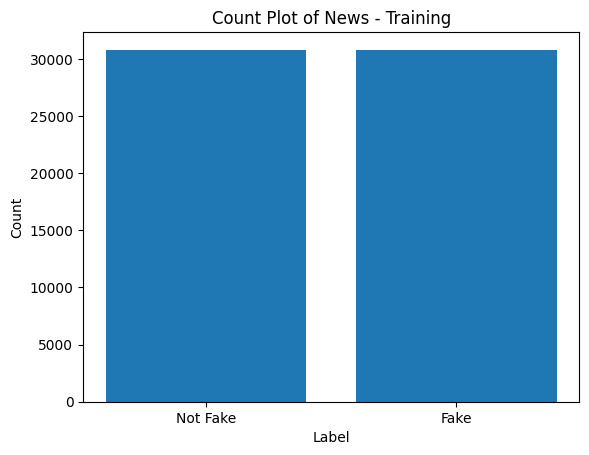

In [45]:
#   The following bar plot shows our data is perfectly balanced, we
#   have the same amount of Fake and Real news in our training dataset.
generate_bar_plot(df_train, 'Count Plot of News - Training')
training_fake = df_train[df_train.label == 1].shape[0]
training_real = df_train[df_train.label == 0].shape[0]
print('Total number of fake news in training data set is ', training_fake)
print('Total number of real news in training data set is ', training_real)

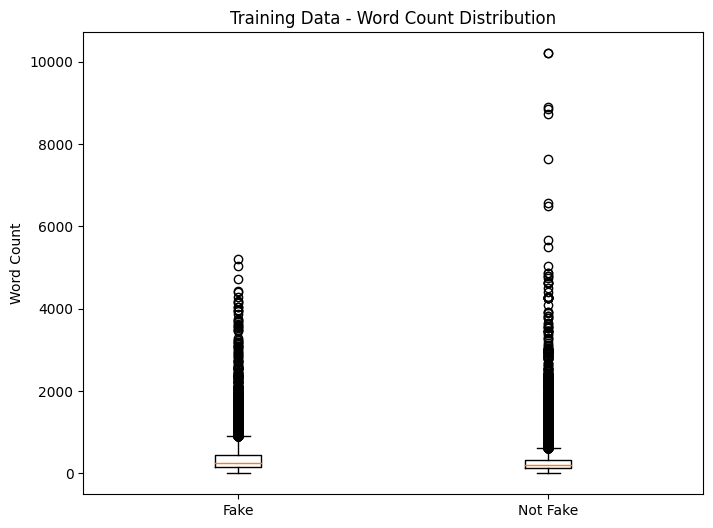

In [46]:
#   Mean word count is 309, although we have many outliers with more than 1000 words
#   approximately
plt.figure(figsize=(8, 6))
plt.boxplot([df_train[df_train['label'] == 1]['word_count'],
             df_train[df_train['label'] == 0]['word_count']],
            labels=['Fake', 'Not Fake'])
plt.ylabel('Word Count')
plt.title('Training Data - Word Count Distribution')
plt.show()

Total number of fake news in testing data set is  7308
Total number of real news in testing data set is  7639


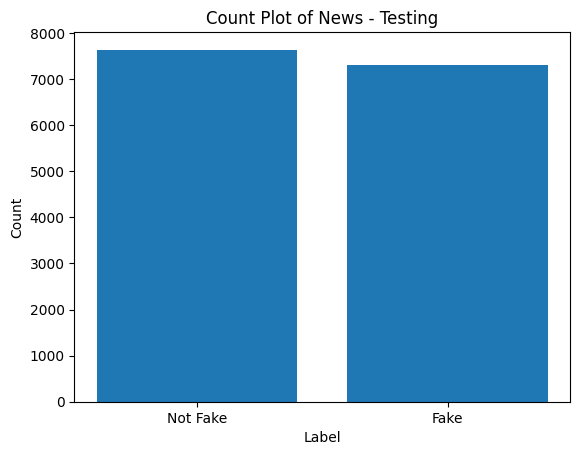

In [47]:
#   We also see some balance in our testing data set
generate_bar_plot(df_test, 'Count Plot of News - Testing')
testing_fake = df_test[df_test.label == 1].shape[0]
testing_real = df_test[df_test.label == 0].shape[0]
print('Total number of fake news in testing data set is ', testing_fake)
print('Total number of real news in testing data set is ', testing_real)

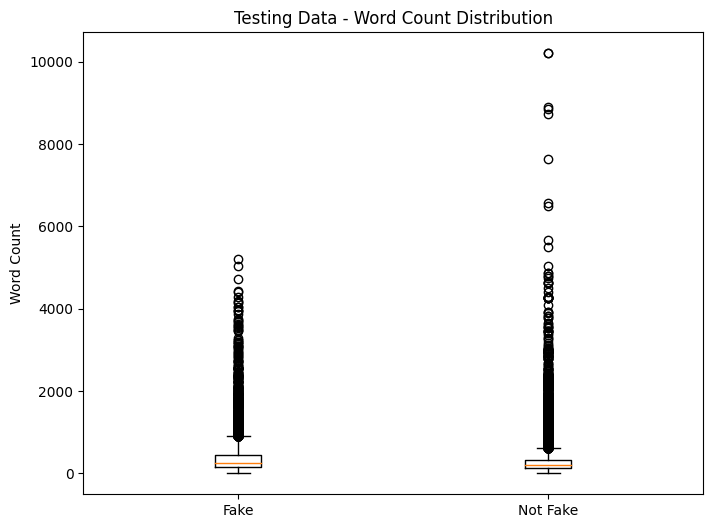

In [48]:
#   Mean word count is 310, although we have many outliers with more than 1000 words
#   approximately
plt.figure(figsize=(8, 6))
plt.boxplot([df_train[df_train['label'] == 1]['word_count'],
             df_train[df_train['label'] == 0]['word_count']],
            labels=['Fake', 'Not Fake'])
plt.ylabel('Word Count')
plt.title('Testing Data - Word Count Distribution')
plt.show()

In [49]:
#   Let's get a hint on the most common topic of all the fake news in our training
#   data set by checking the 10 most frequent words without removing any common ones such
#   as 'and' or 'the'.
word_freq_dict_train = {}

#   Make sure to get the most common words only from news labeled as 'fake'
fake_data_train = df_train[df_train.label == 1]['text']

# Print the ten most frequent words in fake news of training data set
print("From the resulting dictionary we can infer the common topic of the fake news in our training data")
print("is politics as we see 'Trump', and 'president' amongst the ten most frequent words")
for word, freq in find_most_common_words(fake_data_train,word_freq_dict_train).items():
    print(f"{word}: {freq}")

From the resulting dictionary we can infer the common topic of the fake news in our training data
is politics as we see 'Trump', and 'president' amongst the ten most frequent words
say: 195633
trump: 97407
state: 60862
mr: 57338
u: 54490
would: 54427
president: 43990
new: 43129
year: 40542
one: 37590


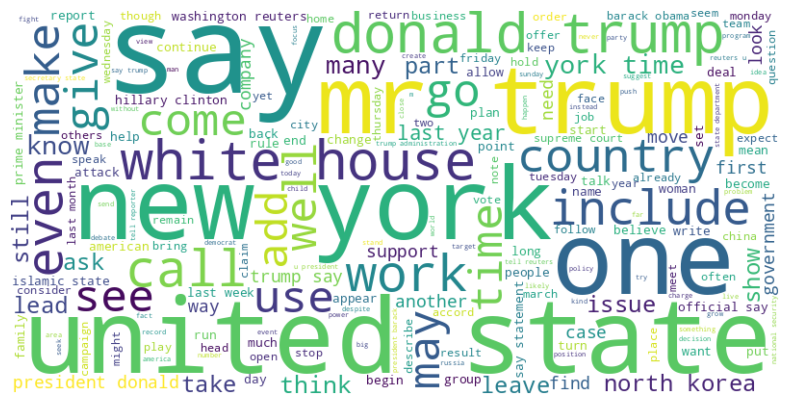

In [50]:
# Joining elements of the list into a single string
text = ' '.join(fake_data_train)

# Generate a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.show()

In [51]:
#   Now Let's get a hint on the most common topic of all the fake news in our testing
#   data set by checking the 10 most frequent words without removing any common ones such
#   as 'and' or 'the'.
word_freq_dict_test = {}

#   Make sure to get the most common words only from news labeled as 'fake'
fake_data_test = df_test[df_test.label == 1]['text']

# Print the ten most frequent words in fake news of training data set
print("From the resulting dictionary we can infer the common topic of the fake news in our training data")
print("is politics as we see 'Trump', and 'president' amongst the ten most frequent words")
for word, freq in find_most_common_words(fake_data_test,word_freq_dict_test).items():
    print(f"{word}: {freq}")

From the resulting dictionary we can infer the common topic of the fake news in our training data
is politics as we see 'Trump', and 'president' amongst the ten most frequent words
say: 46257
trump: 22745
state: 14444
mr: 13487
would: 12825
u: 12813
new: 10657
president: 10607
year: 9810
one: 9320


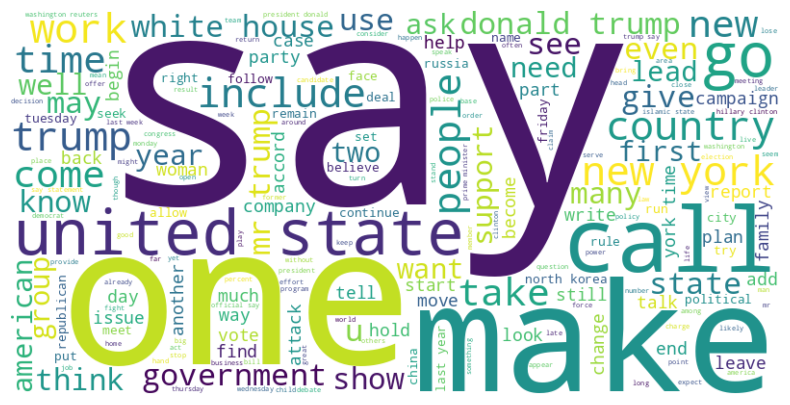

In [52]:
# Joining elements of the list into a single string
text = ' '.join(fake_data_test)

# Generate a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.show()

<strong>DATA PREPROCESSING</strong>

The following is performed during preprocessing:

<ul>
<li>Converting all data to lower case.</li>
<li>Using TfidfVectorizer from sklearn to encode the text data and transform it to numeric vectors.  This vectorizer
considers the importance of words both within a single row and within the whole data set, handles stop words by
reducing their importance, and seems to be better than CountVectorizer for our large training dataset.</li>
</ul>

<strong>PROBLEMS ENCOUNTERED</strong>

<ul>
<li>CountVectorizer was generating issues so TfidfVectorizer was used instead.</li>
<li>CountVectorizer found a total of 256356 unique words in news of both train and test data sets which was generating some errors.</li>
<li>This indicated the training data was too big, which was causing memory issues during vectorization.  
Current training set length is 61590, after several tests it seems the memory errors are gone when reducing
the data set to 30000 rows.  This could still be an issue with the TfidfVectorizer when fitting the models.</li>
<li>It could also indicate that test data is a subset of the data used for training, which needs to be verified.</li>
</ul>




In [ ]:
#   Convert all data to lower case to guarantee unique words are found
df_train['text'] = df_train['text'].str.lower()

#   Vectorize the news data for model learning
vectorizer = TfidfVectorizer()

#   Transform text and assign to train/test matrices
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [ ]:
#   Check the shape of the resulting matrices
print('Shape of resulting encoded training data:', X_train.shape)
print('Shape of resulting encoded testing data:', X_test.shape)

# Printing the identified Unique words along with their indices based on frequency
#print("Vocabulary: ", vectorizer.vocabulary_)
first_five_items = dict(islice(vectorizer.vocabulary_.items(), 50))
print('The first 50 unique words found and their frequencies are:')
print(first_five_items)


Shape of resulting encoded training data: (61590, 256356)
Shape of resulting encoded testing data: (14947, 256356)
The first 50 unique words found and their frequencies are:
{'dark': 51974, 'agenda': 4023, 'behind': 21049, 'globalism': 85437, 'open': 154916, 'border': 26649, 'altmarket': 7894, 'brandon': 27793, 'smith': 206316, 'people': 161786, 'unfamiliar': 236180, 'liberty': 122924, 'movement': 140978, 'stumble': 213959, 'onto': 154768, 'undeniable': 235598, 'fact': 72630, 'conspiracy': 45145, 'tend': 222507, 'look': 125661, 'easy': 63930, 'answer': 10299, 'understand': 235851, 'exist': 71210, 'today': 227917, 'condition': 44183, 'perceive': 162033, 'event': 70050, 'misinterpret': 137584, 'standpoint': 210649, 'occam': 152240, 'razor': 181911, 'wrongly': 251016, 'assume': 14837, 'simple': 204191, 'explanation': 71633, 'probably': 175446, 'right': 188857, 'one': 154254, 'state': 210952, 'instead': 104940, 'summarize': 215071, 'give': 85086, 'evidence': 70443, 'hand': 91254, 'well': 2

In [ ]:
#   Let's verify the frequency of two of the most common words in fake news in the whole training data
trump_value = vectorizer.vocabulary_.get('trump')
president_value = vectorizer.vocabulary_.get('president')
print('Frequency of Trump in whole training data:', trump_value)
print('Frequency of President in whole training data:', president_value)

Frequency of Trump in whole training data: 231382
Frequency of President in whole training data: 174268


<strong>Data Preparation with Tensor Flow</strong>

<ul>
<li><strong>Step 1.  Tokenization</strong><br>Used Tokenizer to break down our news into smaller units, keeping the 10000 most frequent words.</li>
<li><strong>Step 2.  Padding</strong><br>Used pad_sequences to make sure all sentences in our data set had the same shape or same count of words.  Recalling from our data exploration, we found a max word count of
10210 for training, and 11936 for testing data, so we decided to set the max length to the max word count of the two.  All rows were padded to have the same
11936 number of word indexes, so truncation is not necessary.</li>
<li><strong>Step 3.  Embedding</strong><br>  Transforming the words into vectors that capture semantic relationships between them is important in this context, since our model needs to differentiate genuine and fake content.  Our first word embedding choice was GloVe (Global Vectors for Word Representation).  The GloVe file downloaded contains a word followed by 50 numbers which represent the vector of this word's position.  We picked this for simplicity (only 50 dimensions compared to the other ones which had 100, 200, and 300 dimensions).
Due to the size of the file and issues with the definition of the model we decided not to use this file and just added the embedding layer to the model definition without an embedded matrix.</li>
<li>Generated a total of 287230 word indexes from our train and test datasets.</li>
</ul>


In [ ]:
#   Train and test data are already separated, we want to fit the Tokenizer
#   using the whole data, so merging text columns here for this purpose
merged_text_df = pd.concat([df_train, df_test])

#   Initialize Tokenizer by keeping 10000 most frequent words
#   with OOV - Out of Vocabulary token for those words not in the vocabulary
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(merged_text_df['text'])
print(len(tokenizer.word_index))

# Tokenize a sample sentence using the generated word indexes
sentence = "Year of President Trump."
encoded_sentence = tokenizer.texts_to_sequences([sentence])
print(encoded_sentence)

287230
[[12, 1, 9, 3]]


In [ ]:
#  Padding the data to ensure all text rows have the same shape
#   First we tokenize the data
text_sequences = tokenizer.texts_to_sequences(merged_text_df['text'])
#   Setting the max length to our max word count which is 11936
max_word_count = 11936
padded_sequences = pad_sequences(text_sequences, maxlen=max_word_count, padding="post")
#   Split padded sequences back into training and testing sets
#   splitting dataframe by row index
df_train_seq = padded_sequences[0:df_train.shape[0]]
df_test_seq = padded_sequences[df_train.shape[0]:]

#   Check shapes again
print("Training Shape: ", df_train_seq.shape)
print("Testing Shape: ", df_test_seq.shape)

#   Get all words and their corresponding indexes from our data
word_idxs = tokenizer.word_index
#   Get the size of our data vocabulary
v_size = len(word_idxs)
#   We are using gloVe with 50 dimensions so our embedding dimension is
#   50
embedding_dimension = 50

#   Prepare training and testing labels
y_train = (df_train['label'])
y_test = (df_test['label'])

Training Shape:  (61590, 11936)
Testing Shape:  (14947, 11936)


<h1>Model Architecture and Design - First Dataset</h1>

<h1>Logistic Regression</h1>
We trained a single Logistic Regression Model using the vectorized data set. Here we obtained good scores indicating a good fit of the model to current data:
<ul>
<li>The precision of prediction of both fake and genuine news was above 90% (96% fake, 94% true)</li>
<li>The percentage of fake and genuine news correctly identified was above 90% (93% fake recall, 96% true recall)</li>
<li>Accuracy is high with 95%</li>
<li>F1 Scores are balanced with 95%.</li>
</ul>

In [ ]:
# Initializing the logistic regression model
logistic_reg = LogisticRegression()

# Training the model
logistic_reg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = logistic_reg.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generating a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9472803907138556
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7639
           1       0.96      0.93      0.95      7308

    accuracy                           0.95     14947
   macro avg       0.95      0.95      0.95     14947
weighted avg       0.95      0.95      0.95     14947



<h1>Multilayer Perceptron</h1>
Due to limitations caused by memory contraints and computational time we decided to use a single Multilayer Perceptron model.
Specifications were as follows:
<ul>
<li>Two hidden layers, first with 100 neurons and second with 50 neurons.</li>
<li>ReLU Activation function was specified for all hidden layers.</li>
<li>Adam as the optimization algorithm as it is an efficient variant of the Stochastic Gradient Descent (SGD)</li>
</ul>

<strong>Results</strong>
<ul>
<li>The precision of prediction of both fake and genuine news was above 90% (95% fake, 96% true)</li>
<li>The percentage of fake and genuine news correctly identified was above 90% (96% fake recall, 95% true recall)</li>
<li>Accuracy is high with 95%</li>
<li>F1 Scores are fairly balanced with only 1% difference</li>
</ul>


In [ ]:
# Define the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = mlp_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9556432728975714
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      7639
           1       0.95      0.96      0.95      7308

    accuracy                           0.96     14947
   macro avg       0.96      0.96      0.96     14947
weighted avg       0.96      0.96      0.96     14947



c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


<h1>Transformer - NLP</h1>
<ul>
<li><strong>Step 1.  Initial Model</strong><br>
First objective was to get the model to compile and fit the training data to obtain an initial set of accuracy/loss values for both training and testing data.  We started with just a single dense layer with relu activation, another one with sigmoid activation for this is a binary classification problem, and a combination of embedding and GlobalAveragePooling1D layers for the sequential data.  We could see from the accuracy/loss comparisons that this model was not performing well so we started with the tuning process.
</li>
<li><strong>Step 2.  Tuning</strong><br>
To increase our model's capacity we added more dense layers to it, and decided to start using regularization.  Our first pick was using a combination of l1 and l2 regularization with the same strength parameter of 0.002.  <br>To help with the computational time constraints we reduced the epochs parameter from 20 to 10 for all trials.  Because of these constraints we decided to do fine tuning on three models only.<br>
For the third model we tried some layers recommended to reduce overfitting and other issues such as dropout, BatchNormalization to stabilize training and improve convergence, and EarlyStopping to prevent overfitting and save training time.  We tried adding a layer with LSTM (Long Short-Term Memory) to improve representation learning, but unexpected errors prevented it.
All models were compiled with Adam optimizer using the default learning rate.
</li>
<li><strong>Step 3.  Results</strong><br>
<strong>The first model</strong> did not perform well, its training accuracy was very low with highest barely reaching 53%, and highest validation accuracy reaching 55%.  Some fluctuations in the loss plots indicate poor initialization.<br>
<strong>The second model</strong> performed better in terms of generalization showing both training and validation loss were gradually descending, being the validation loss lower than the training (or close to it) for most of the iterations.  However, the accuracy did not agree with this better generalization with fluctuations indicating overfitting or other learning issues.  This model requires more tuning.<br>
<strong>The third model</strong> seemed to show some improvement in accuracy, but the plots showed it was clearly overfitting so more tuning was necessary.  Unfortunately, due the many memory and computational time constraints, further tuning was very difficult.
</li>
</ul>

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 11936, 50)      │    14,361,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,362,333 (54.79 MB)

 Trainable params: 14,362,333 (54.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


c:\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 412ms/step - accuracy: 0.4993 - loss: 0.6938 - val_accuracy: 0.4893 - val_loss: 0.6938
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 49s 406ms/step - accuracy: 0.4995 - loss: 0.6944 - val_accuracy: 0.4891 - val_loss: 0.6961
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 49s 405ms/step - accuracy: 0.5065 - loss: 0.6934 - val_accuracy: 0.5263 - val_loss: 0.6917
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 397ms/step - accuracy: 0.5093 - loss: 0.6927 - val_accuracy: 0.5501 - val_loss: 0.6914
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.5242 - loss: 0.6917 - val_accuracy: 0.4901 - val_loss: 0.6927
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.5270 - loss: 0.6912 - val_accuracy: 0.5144 - val_loss: 0.6896
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.5285 - loss: 0.6905 - val_accuracy: 0.4895 - val_loss: 0.6981
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.5257 - loss: 0.6904 - val

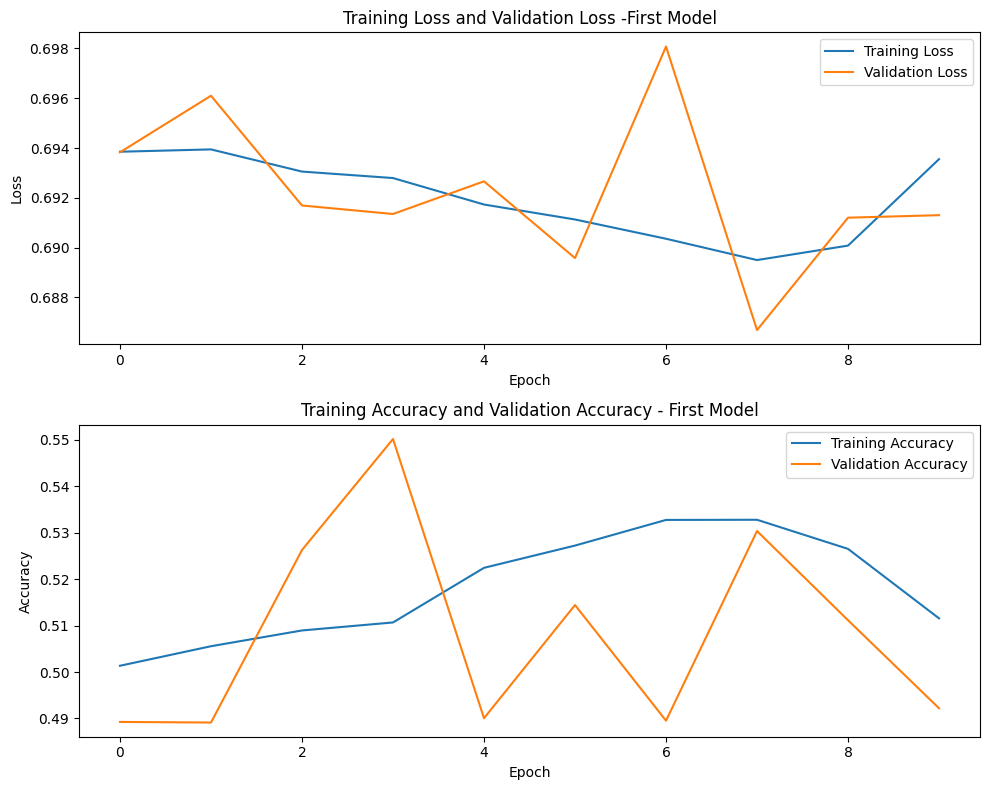

In [ ]:
# Including Embedding layer
tf_model = Sequential([
  tf.keras.layers.Input((df_train_seq.shape[1], )),
  tf.keras.layers.Embedding(v_size, embedding_dimension, name="embedding"),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1,activation="sigmoid")
])

tf_model.summary()

tf_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#   Training the model
tf_history = tf_model.fit(
    df_train_seq, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(df_test_seq, y_test),
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs")]
)

#   First model Plots Accuracy/Loss Comparisons
plot_history(tf_history.history, 'First Model')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 11936, 50)      │    14,361,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,362,605 (54.79 MB)

 Trainable params: 14,362,605 (54.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 49s 402ms/step - accuracy: 0.5018 - loss: 0.8147 - val_accuracy: 0.5111 - val_loss: 0.7706
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 49s 401ms/step - accuracy: 0.5038 - loss: 0.7606 - val_accuracy: 0.4889 - val_loss: 0.7344
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 398ms/step - accuracy: 0.5016 - loss: 0.7276 - val_accuracy: 0.4889 - val_loss: 0.7121
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.5019 - loss: 0.7087 - val_accuracy: 0.5109 - val_loss: 0.7020
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 391ms/step - accuracy: 0.5020 - loss: 0.7012 - val_accuracy: 0.5111 - val_loss: 0.6991
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 391ms/step - accuracy: 0.5005 - loss: 0.6988 - val_accuracy: 0.5253 - val_loss: 0.6974
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 395ms/step - accuracy: 0.5014 - loss: 0.6971 - val_accuracy: 0.5109 - val_loss: 0.6960
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.5024 - loss: 0

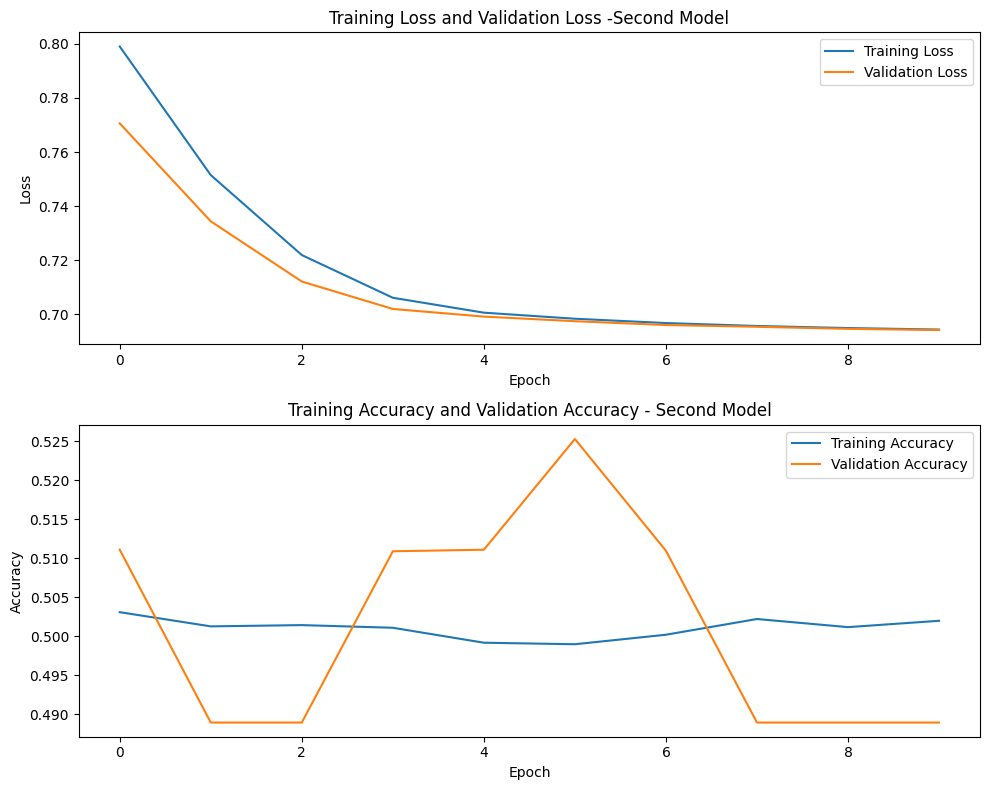

In [ ]:
# Define, compile, and fit second model with additional dense layers and regularization
tf_model1 = Sequential([
  tf.keras.layers.Input((df_train_seq.shape[1], )),
  tf.keras.layers.Embedding(v_size, embedding_dimension, name="embedding"),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.002, l2=0.002)),
  tf.keras.layers.Dense(1,activation="sigmoid")
])

tf_model1.summary()

tf_model1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#   Training the model
tf_history1 = tf_model1.fit(
    df_train_seq, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(df_test_seq, y_test),
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs")]
)

plot_history(tf_history1.history, 'Second Model')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 11936, 50)      │    14,361,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11936, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11936, 50)      │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,362,533 (54.79 MB)

 Trainable params: 14,362,433 (54.79 MB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6621 - loss: 0.9023 - val_accuracy: 0.6916 - val_loss: 0.8261
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.8616 - loss: 0.6243 - val_accuracy: 0.4943 - val_loss: 0.8385
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9051 - loss: 0.4807 - val_accuracy: 0.9031 - val_loss: 0.6222
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9238 - loss: 0.4180 - val_accuracy: 0.5203 - val_loss: 1.7427
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9289 - loss: 0.3817 - val_accuracy: 0.5576 - val_loss: 0.9557
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9393 - loss: 0.3513 - val_accuracy: 0.9052 - val_loss: 0.3903
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9461 - loss: 0.3266 - val_accuracy: 0.6054 - val_loss: 0.9250
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9496 - loss: 0.3063 - val_accu

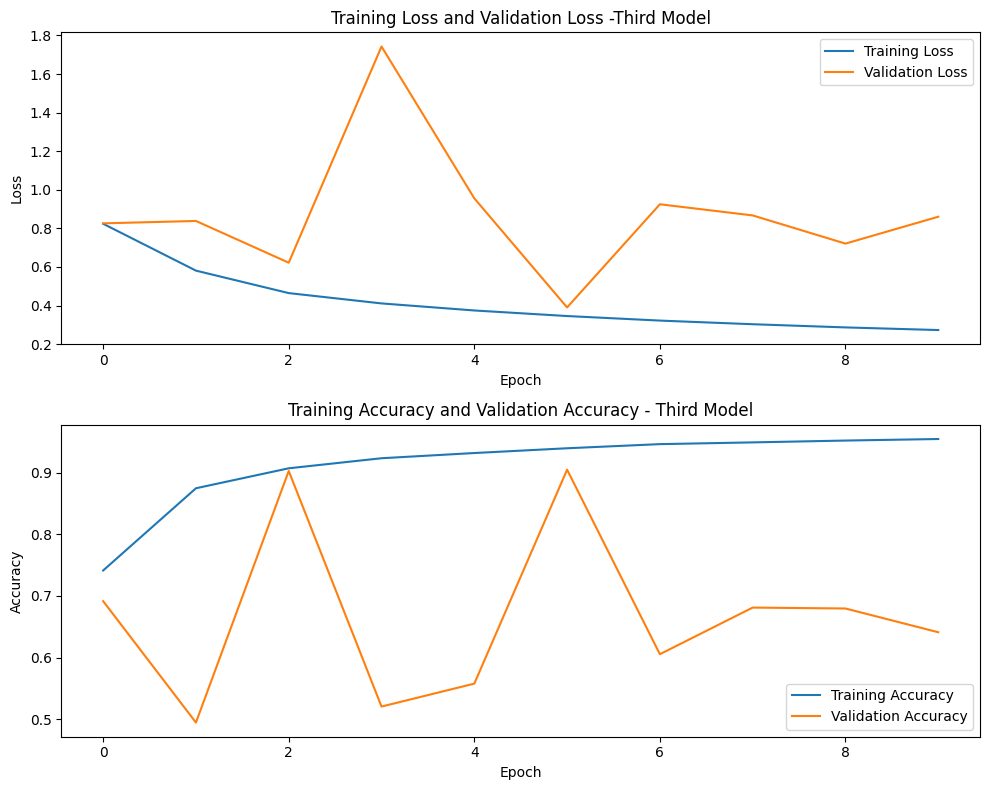

In [ ]:
# Define, compile, and fit third model with dropout, convolutional layer, lstm additional dense layers and regularization
tf_model2 = Sequential([
    tf.keras.layers.Input((df_train_seq.shape[1], )),
    tf.keras.layers.Embedding(v_size, embedding_dimension, name="embedding"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.002, l2=0.002)),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

tf_model2.summary()

tf_model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#   Training the model
tf_history2 = tf_model2.fit(
    df_train_seq, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(df_test_seq, y_test),
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir="logs")]
)

plot_history(tf_history2.history, 'Third Model')

<h1>Data Preparation - Dataset 2</h1>

WELFake is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

There are 78098 data entries in csv file out of which only 72134 entries are accessed as per the data frame.

Published in:
IEEE Transactions on Computational Social Systems: pp. 1-13 (doi: 10.1109/TCSS.2021.3068519).


<strong>Source</strong>
>
https://zenodo.org/records/4561253/files/WELFake_Dataset.csv

In [8]:
# URL of the CSV file
url = "https://zenodo.org/records/4561253/files/WELFake_Dataset.csv"

# Read the CSV file from the URL
df_WEL = pd.read_csv(url)

print(df_WEL.head())  # Print the first few rows of the DataFrame

   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


In [9]:
#   Print Details of dataset
print("Fake of real DATA SET")
print("-----------------")
print('Shape:', df_WEL.shape)
print('Info:')
print(df_WEL.info())
print('Description:')
print(df_WEL.describe())
print('nulls?')
print(df_WEL.isnull().sum())

Fake of real DATA SET
-----------------
Shape: (72134, 4)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
Description:
         Unnamed: 0         label
count  72134.000000  72134.000000
mean   36066.500000      0.514404
std    20823.436496      0.499796
min        0.000000      0.000000
25%    18033.250000      0.000000
50%    36066.500000      1.000000
75%    54099.750000      1.000000
max    72133.000000      1.000000
nulls?
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64


Below I check to see if the date is balanced between real and fake.

In [10]:
# Drop rows with null values in the 'text' column
df_WEL = df_WEL.dropna(subset=['text'])

# Reset the index
df_WEL = df_WEL.reset_index(drop=True)

In [11]:
value_counts = df_WEL['label'].value_counts()

print("Occurrences of each unique value in the column:")
print(value_counts)

Occurrences of each unique value in the column:
label
1    37067
0    35028
Name: count, dtype: int64


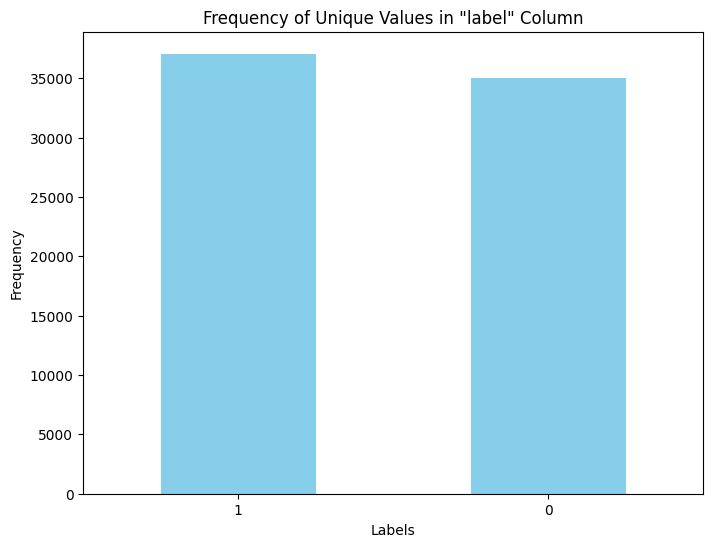

In [12]:
# Plot the frequencies
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Unique Values in "label" Column')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.show()

In [7]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\damia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\damia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Filter the DataFrame to include only rows with label '0'
df_label_0 = df_WEL[df_WEL['label'] == 0]

# Combine text into a single string
text = ' '.join(df_label_0['text'])

# Tokenize the text
tokens = word_tokenize(text)

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Remove punctuation
tokens_no_punct = [word for word in tokens if word not in string.punctuation]

# Filter out stopwords
filtered_tokens = [word for word in tokens_no_punct if word.lower() not in stop_words]

# Count the occurrences of each word
word_counts = Counter(filtered_tokens)

# Get the 10 most common words
most_common_words = word_counts.most_common(10)
most_common_words_excluded = most_common_words[3:]

print(most_common_words_excluded)

[('said', 184453), ('Trump', 106043), ('Mr.', 64676), ('would', 62318), ('—', 45763), ('U.S.', 39951), ('people', 38980)]


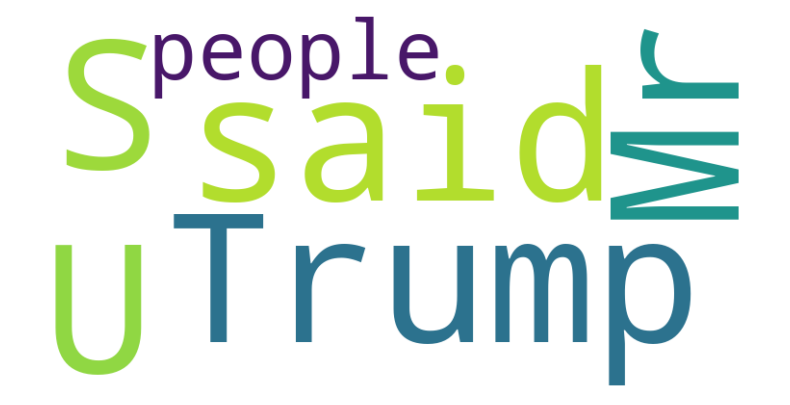

In [17]:
# Extract words from tuples and join them into a single string
text = ' '.join(word for word, _ in most_common_words)

# Generate a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axis
plt.show()

<strong>DATA PREPROCESSING</strong>

The following is performed during preprocessing:
- Data was tokenized using nltk tokenizing. This process breaks down the word into tokens to analyze. From there i removed the stopwords and punctuation for better insight into the most common words.
- May need to use word2vect further down the road for the text and labels


<strong>PROBLEMS ENCOUNTERED</strong>

<ul>
<li>Data is very large which took a lot of time to process the tokenization. Going forward will most likely use Google Collab</li>
<li>Even with no punction being requested during the tokenization, the three most common tokens were not words. I got around this by skipping the first three tokens and using 2-12</li>
<li>Could not prep the data for the Transformer to error:  <i>Unable to allocate 5.33 GiB for an array with shape (57676, 24814) and data type int32</i></li>
</ul>

<h1>Model Architecture and Design - Dataset 2</h1>
<h1>Logistic Regression Model</h1>

<ul>
<li>The precision of prediction of both fake and genuine news was above 90% (94% fake, 95% true)</li>
<li>The percentage of fake and genuine news correctly identified was above 90% (95% fake recall, 93% true recall)</li>
<li>Accuracy is high with 94%</li>
<li>F1 Scores are balanced</li>
</ul>

In [19]:
# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf_WEL = tfidf_vectorizer.fit_transform(X_WEL)

# Split data into training and testing sets
X_train_WEL, X_test_WEL, y_train_WEL, y_test_WEL = train_test_split(X_tfidf_WEL, y_WEL, test_size=0.2, random_state=42)

# Train a logistic regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_WEL, y_train_WEL)

# Predict on the testing set
y_pred_WEL = logistic_regression.predict(X_test_WEL)

# Evaluate the model
accuracy = logistic_regression.score(X_test_WEL, y_test_WEL)
print("Accuracy:", accuracy)

# Generating a classification report
print("Classification Report:")
print(classification_report(y_test_WEL, y_pred_WEL))

Accuracy: 0.9428531798321659
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7010
           1       0.94      0.95      0.94      7409

    accuracy                           0.94     14419
   macro avg       0.94      0.94      0.94     14419
weighted avg       0.94      0.94      0.94     14419



<h1>Multilayer Perceptron</h1>

<strong>Results</strong>
<ul>
<li>The precision of prediction of both fake and genuine news was above 90% (94% fake, 95% true)</li>
<li>The percentage of fake and genuine news correctly identified was above 90% (95% fake recall, 93% true recall)</li>
<li>Accuracy is high with 94%</li>
<li>F1 Scores are balanced with both at 94%</li>
</ul>

In [53]:
# Define the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

# Train the model
mlp_model.fit(X_train_WEL, y_train_WEL)

# Make predictions on the testing set
y_pred_WEL_MLP = mlp_model.predict(X_test_WEL)

# Evaluate the model
accuracy_MLP = accuracy_score(y_test_WEL, y_pred_WEL_MLP)
print("Accuracy:", accuracy_MLP)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test_WEL, y_pred_WEL))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 0.959844649420903
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7010
           1       0.94      0.95      0.94      7409

    accuracy                           0.94     14419
   macro avg       0.94      0.94      0.94     14419
weighted avg       0.94      0.94      0.94     14419



<h1>Data Preparation - Dataset 3</h1>

Our third dataset comprises a complete sample of news published in Facebook from 9 news agencies over a week close to the 2016 U.S. election. Every post and the linked article were fact-checked claim-by-claim by 5 BuzzFeed journalists. It contains 1,627 articles 826 mainstream, 356 left-wing, and 545 right-wing articles.

<strong>source</strong>
>https://raw.githubusercontent.com/BuzzFeedNews/2016-10-facebook-fact-check/master/data/facebook-fact-check.csv


In [3]:
df_fb = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/2016-10-facebook-fact-check/master/data/facebook-fact-check.csv')

print(df_fb.head())  # Print the first few rows of the DataFrame

        account_id           post_id    Category               Page  \
0  184096565021911  1035057923259100  mainstream  ABC News Politics   
1  184096565021911  1035269309904628  mainstream  ABC News Politics   
2  184096565021911  1035305953234297  mainstream  ABC News Politics   
3  184096565021911  1035322636565962  mainstream  ABC News Politics   
4  184096565021911  1035352946562931  mainstream  ABC News Politics   

                                            Post URL Date Published Post Type  \
0  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19     video   
1  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19      link   
2  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19      link   
3  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19      link   
4  https://www.facebook.com/ABCNewsPolitics/posts...     2016-09-19     video   

               Rating Debate  share_count  reaction_count  comment_count  
0  no factu

In [4]:
#   Print Details of dataset
print("Facebook DATA SET")
print("-----------------")
print('Shape:', df_fb.shape)
print('Info:')
print(df_fb.info())
print('Description:')
print(df_fb.describe())
print('nulls?')
print(df_fb.isnull().sum())


Facebook DATA SET
-----------------
Shape: (2282, 12)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   account_id      2282 non-null   int64  
 1   post_id         2282 non-null   int64  
 2   Category        2282 non-null   object 
 3   Page            2282 non-null   object 
 4   Post URL        2282 non-null   object 
 5   Date Published  2282 non-null   object 
 6   Post Type       2282 non-null   object 
 7   Rating          2282 non-null   object 
 8   Debate          298 non-null    object 
 9   share_count     2212 non-null   float64
 10  reaction_count  2280 non-null   float64
 11  comment_count   2280 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 214.1+ KB
None
Description:
         account_id       post_id   share_count  reaction_count  comment_count
count  2.282000e+03  2.282000e+03  2.21200

In [5]:
# Drop rows with null values in the 'text' column
df_fb = df_fb.dropna(subset=['share_count', 'reaction_count', 'comment_count'])

# Reset the index
df_fb= df_fb.reset_index(drop=True)

Below we will take a look at the different unique values to gain more insight on what our data contains

In [13]:
value_count_rat = df_fb['Rating'].value_counts()

print("Occurrences of each unique value in the column:")
print(value_counts)

Occurrences of each unique value in the column:
label
1    37067
0    35028
Name: count, dtype: int64


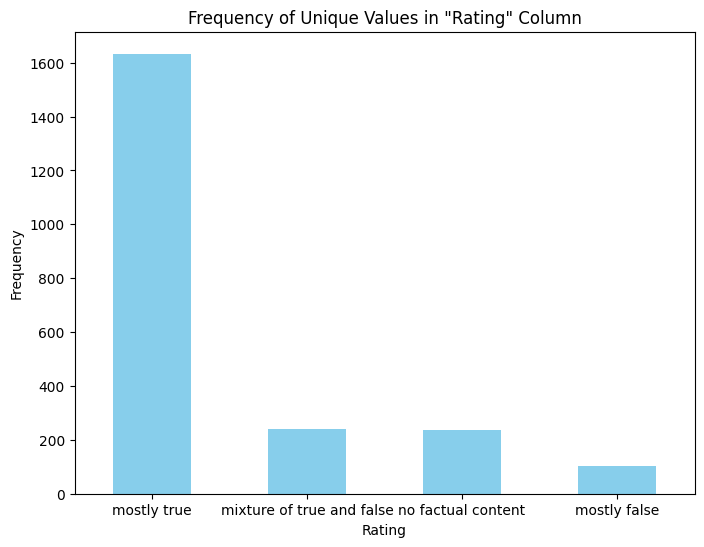

In [14]:
# Plot the frequencies
plt.figure(figsize=(8, 6))
value_count_rat.plot(kind='bar', color='skyblue')
plt.title('Frequency of Unique Values in "Rating" Column')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.show()

In [15]:
value_count_cat = df_fb['Category'].value_counts()

print("Occurrences of each unique value in the column:")
print(value_counts)

Occurrences of each unique value in the column:
label
1    37067
0    35028
Name: count, dtype: int64


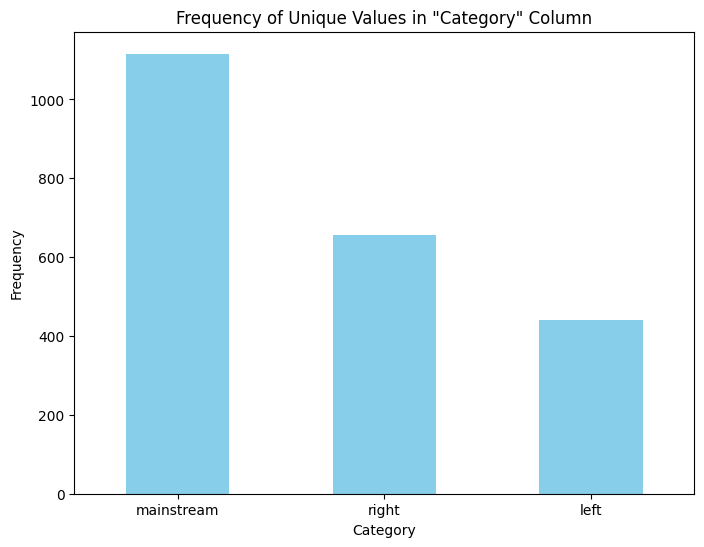

In [16]:
# Plot the frequencies
plt.figure(figsize=(8, 6))
value_count_cat.plot(kind='bar', color='skyblue')
plt.title('Frequency of Unique Values in "Category" Column')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.show()

In [17]:
count_matches = df_fb.groupby(['Category', 'Rating']).size().reset_index(name='Count')

print(count_matches)

      Category                     Rating  Count
0         left  mixture of true and false     65
1         left               mostly false     21
2         left                mostly true    250
3         left         no factual content    105
4   mainstream  mixture of true and false      8
5   mainstream                mostly true   1067
6   mainstream         no factual content     41
7        right  mixture of true and false    168
8        right               mostly false     82
9        right                mostly true    316
10       right         no factual content     89


c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


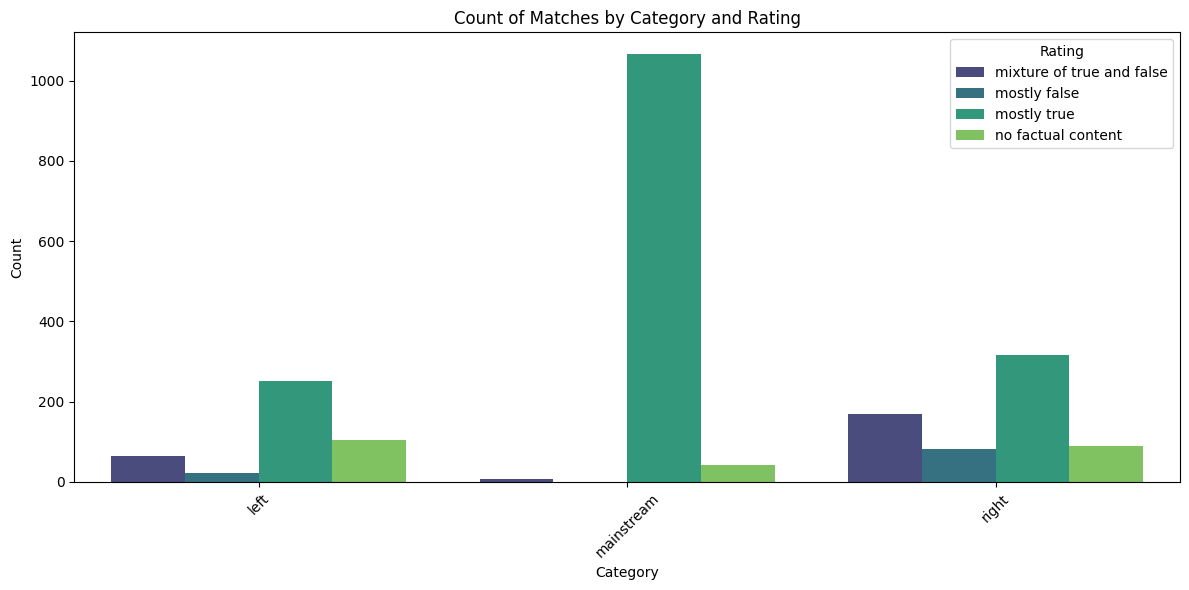

In [18]:
# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Count', hue='Rating', data=count_matches, palette='viridis')
plt.title('Count of Matches by Category and Rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<strong>DATA PREPROCESSING</strong>

The following is performed during preprocessing:

- Data was extremely clean so no need to preprocess yet. There were NAN values, however, they were from columns that most likely will not be used for analysis. The most important columns , Category and Rating, had no NANs.
- Potentially i can see the need to use word2vec for both the text as well as the Ratings and Category

<strong>PROBLEMS ENCOUNTERED</strong>

- As stated above data was very clean and there were no complications

<h1>Model Architecture and Design - Dataset 3</h1>
<h1>Logistic Regression Model</h1>

We wanted to play with this dataset just to observe some of the implications that unbalanced data would have, we know our logistic regression model won't yield good results as we did not balance our data.

<strong>Results</strong>
<ul>
<li>The majority of the data had a rating of 'mostly true' so the model performed well on this and very poorly on the less common ratings.  We can see that accuracy predicting the most common rating was high (98% for 'mostly true'), the F1 Scores were not balanced at all and model accuracy was very low compared to the other models (76%).
</li>
<li>To compensate for this we decided to include an additional Gradient Boosting Classiffier model to compare performances.</li>
</ul>

In [27]:
le = LabelEncoder()
df_fb['Category'] = le.fit_transform(df_fb['Category'])

# Define features and labels
X_fb = df_fb[['share_count', 'reaction_count', 'comment_count', 'Category']]
y_fb = df_fb['Rating']

# Split data into training and testing sets
X_train_fb, X_test_fb, y_train_fb, y_test_fb = train_test_split(X_fb, y_fb, test_size=0.2, random_state=42)

# Train a logistic regression model
logistic_regression = LogisticRegression(multi_class='multinomial', solver='newton-cg')
logistic_regression.fit(X_train_fb, y_train_fb)

# Predict on the testing set
y_pred_fb = logistic_regression.predict(X_test_fb)

# Evaluate the model
accuracy_fb = logistic_regression.score(X_test_fb, y_test_fb)
print("Accuracy:", accuracy_fb)

# Generating a classification report
print("Classification Report:")
print(classification_report(y_test_fb, y_pred_fb))

Accuracy: 0.7629796839729119
Classification Report:
                           precision    recall  f1-score   support

mixture of true and false       0.00      0.00      0.00        39
             mostly false       0.00      0.00      0.00        14
              mostly true       0.78      0.98      0.87       338
       no factual content       0.44      0.15      0.23        52

                 accuracy                           0.76       443
                macro avg       0.31      0.28      0.27       443
             weighted avg       0.65      0.76      0.69       443



c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

<h1>Gradient Boosting</h1>

with this model we were able to get some scores for the less common response classes but the accuracy was still very low.  Working with this data using these models requires some balancing technique.  We tried one recommended for Python called SMOTE (Synthetic Minority Over-sampling Technique), but due to some errors with the library we had to remove it from the project.

<strong>Results</strong>
<ul>
<li>With GB Model we still had the highest precision and recall at 83% and 94% respectively for the most common rating which is 'mostly true', so our model is still showing some bias.</li>
<li>Accuracy was still low at 78%</li>
<li>F1 Scores are still not balanced with highest at 88% for the most common rating.</li>
</ul>

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

#   Define and fit a Gradient Boosting Classifier on unbalanced data to compare results
gb_model_fb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model_fb.fit(X_train_fb, y_train_fb)

#   Use model to perform predictions
y_pred_fb = gb_model_fb.predict(X_test_fb)

# Generating a classification report
print("Classification Report:")
print(classification_report(y_test_fb, y_pred_fb))

Classification Report:
                           precision    recall  f1-score   support

mixture of true and false       0.33      0.18      0.23        39
             mostly false       0.31      0.29      0.30        14
              mostly true       0.83      0.94      0.88       338
       no factual content       0.64      0.31      0.42        52

                 accuracy                           0.78       443
                macro avg       0.53      0.43      0.46       443
             weighted avg       0.75      0.78      0.75       443



<h1>Multilayer Perceptron</h1>

Again we are seeing some bias in all models for this data.  Best scores are for the most common rating.

<ul>
<li>Highest precision and recall at 85% and 71% respectively for the most common rating which is 'mostly true'.</li>
<li>Accuracy was still low at 62%</li>
<li>F1 Scores are still not balanced with highest at 77% for the most common rating.</li>
</ul>

In [35]:
# Define the MLP model
mlp_model_fb = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

# Train the model
mlp_model.fit(X_train_fb, y_train_fb)

# Make predictions on the testing set
y_pred_fb = mlp_model.predict(X_test_fb)

# Evaluate the model
accuracy_fb = accuracy_score(y_test_fb, y_pred_fb)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test_fb, y_pred_fb))

Accuracy: 0.9428531798321659
Classification Report:
                           precision    recall  f1-score   support

mixture of true and false       0.33      0.26      0.29        39
             mostly false       0.00      0.00      0.00        14
              mostly true       0.85      0.71      0.77       338
       no factual content       0.21      0.52      0.30        52

                 accuracy                           0.62       443
                macro avg       0.35      0.37      0.34       443
             weighted avg       0.70      0.62      0.65       443



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h1>FINAL EVALUATION/THOUGHTS</h1>

<strong>FIRST DATA SET</strong><br>

This data set was the cleanest and despite some initial memory constraints issue we were able to preprocess the data and train all three of our target models with it.

Both Logistic Regression and MLP Models returned the same accuracy, but further study is needed to verify the validity of these scores as the parameters used were the most basic ones.

The NLP model was the most important one for this type of problem because of its practical relevance.  All steps to explore and preprocess the data.  Unfortunately, due to memory constraints, we couldn’t move further into the tuning process. However, this example aligns well with the type of problems this model is good at.  The accuracy and other scores of this model were still very low when the memory issues started.

<strong>SECOND DATA SET</strong><br>

This data set was as good as the first one used, but bigger,  so time and memory constraints played even a bigger role in defining and executing all the target models for comparison.

We encountered significant challenges while attempting to preprocess the data for the NLP model. Due to these difficulties, we couldn’t proceed with the model implementation beyond the preprocessing stage.

Both the Logistic Regression and Multilayer Perceptron models achieved excellent accuracy scores. However, due to the mentioned limitations, implementing the MLP posed some challenges. Further research is needed to validate the reliability of these models. 

<strong>THIRD DATA SET</strong><br>

This dataset posed a different challenge due to its imbalanced nature. During our initial data exploration, we experimented with recommended techniques in Python to mitigate this issue. However, additional work is still required.

To address the imbalance, we introduced a Gradient Boosting (GB) model. Unfortunately, the results were comparable to the other models. None of the three models achieved an accuracy score above 80%, with the Multilayer Perceptron (MLP) performing the worst.

Moving forward, we need to do more data exploration, including balancing and model tuning, to improve performance.